# Phase 4: Feature Importance Experiments

**Objective**: Investigate the influence of different feature combinations on model accuracy and identify the optimal feature set for student performance prediction.

## Tasks:
1. Feature importance analysis using multiple methods (Permutation, SHAP)
2. Feature selection experiments with different combinations
3. Dimensionality reduction (PCA)
4. Deep SHAP analysis for model interpretability
5. Feature interaction analysis
6. Recommendations for optimal feature sets

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import shap

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data and Models

In [5]:
# Load processed data
data_path = '../data/processed/oulad/oulad_with_clusters.csv'
df = pd.read_csv(data_path)

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns
print(f"\nTarget distribution:")
print(df['final_result'].value_counts())

Data shape: (32593, 49)
Columns: ['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits']...

Target distribution:
final_result
Pass           12361
Withdrawn      10156
Fail            7052
Distinction     3024
Name: count, dtype: int64


In [6]:
# Load trained models and artifacts from Phase 3
models_path = '../models/'

with open(models_path + 'lightgbm_model.pkl', 'rb') as f:
    lgbm_model = pickle.load(f)

with open(models_path + 'xgboost_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

with open(models_path + 'random_forest_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open(models_path + 'decision_tree_model.pkl', 'rb') as f:
    dt_model = pickle.load(f)

with open(models_path + 'label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open(models_path + 'feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print("Models loaded successfully!")
print(f"Total features: {len(feature_names)}")

Models loaded successfully!
Total features: 67


In [7]:
# Prepare features and target
# Drop non-feature columns
drop_cols = ['id_student', 'code_module', 'code_presentation', 'final_result']
if 'student_course_id' in df.columns:
    drop_cols.append('student_course_id')

X = df.drop(columns=drop_cols)
y = df['final_result']

# Encode target
y_encoded = label_encoder.transform(y)

# One-hot encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

# Check for duplicate columns BEFORE aligning
print(f"\nAfter get_dummies: {X_encoded.shape}")
if X_encoded.columns.duplicated().any():
    dup_cols = X_encoded.columns[X_encoded.columns.duplicated()].unique().tolist()
    print(f"WARNING: {len(dup_cols)} duplicate column names found!")
    print(f"Duplicates: {dup_cols[:10]}")  # Show first 10
    # Keep only first occurrence of duplicates
    X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated(keep='first')]
    print(f"After removing duplicates: {X_encoded.shape}")

print(f"Features in X_encoded: {len(X_encoded.columns)}")
print(f"Features expected by model: {len(feature_names)}")

# Check if feature_names has duplicates
if len(feature_names) != len(set(feature_names)):
    print(f"\nWARNING: feature_names from model has duplicates!")
    from collections import Counter
    name_counts = Counter(feature_names)
    dups = {k: v for k, v in name_counts.items() if v > 1}
    print(f"Duplicate features in model: {list(dups.keys())[:10]}")
    
    # Remove duplicates from feature_names
    seen = set()
    feature_names_clean = []
    for name in feature_names:
        if name not in seen:
            feature_names_clean.append(name)
            seen.add(name)
    feature_names = feature_names_clean
    print(f"Cleaned feature_names: {len(feature_names)}")

# Align features with trained model
# Add missing features (fill with 0)
missing_features = set(feature_names) - set(X_encoded.columns)
if missing_features:
    print(f"\nAdding {len(missing_features)} missing features")
    for feat in missing_features:
        X_encoded[feat] = 0

# Remove extra features not in model
extra_features = set(X_encoded.columns) - set(feature_names)
if extra_features:
    print(f"Removing {len(extra_features)} extra features")
    X_encoded = X_encoded.drop(columns=list(extra_features))

# Reorder to match model
X_encoded = X_encoded[feature_names]

# Final check for duplicates
if X_encoded.columns.duplicated().any():
    print(f"\nERROR: Still have duplicates after alignment!")
    X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated(keep='first')]

print(f"\nFinal feature matrix shape: {X_encoded.shape}")
print(f"Target shape: {y_encoded.shape}")
print(f"Duplicate columns: {X_encoded.columns.duplicated().sum()}")

Categorical columns: ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability']

After get_dummies: (32593, 73)
Duplicates: ['gender_M', 'disability_Y']
After removing duplicates: (32593, 71)
Features in X_encoded: 71
Features expected by model: 67

Duplicate features in model: ['gender_M', 'disability_Y']
Cleaned feature_names: 65
Removing 6 extra features

Final feature matrix shape: (32593, 65)
Target shape: (32593,)
Duplicate columns: 0


In [8]:
# Split data (use same random state as Phase 3 for consistency)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

# Verify no duplicates in column names
assert not X_train.columns.duplicated().any(), "ERROR: X_train has duplicate columns!"
assert not X_test.columns.duplicated().any(), "ERROR: X_test has duplicate columns!"

print(f"✓ No duplicate columns in train/test sets")

Train size: (26074, 65)
Test size: (6519, 65)
✓ No duplicate columns in train/test sets


## 2. Permutation Importance Analysis

Permutation importance measures how much model performance decreases when a feature's values are randomly shuffled. This is a model-agnostic method.

In [10]:
# Note: We skip permutation importance on the Phase 3 model because:
# 1. The Phase 3 model was trained with 67 features (including duplicates)
# 2. After cleaning duplicates, we now have 65 unique features
# 3. The feature mismatch makes it incompatible
# 
# Instead, we'll train a fresh LightGBM model and compute all importance metrics on it

print("Training a new LightGBM model on cleaned data for importance analysis...")

from lightgbm import LGBMClassifier

# Train new model with cleaned features
lgbm_clean = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42,
    verbose=-1,
    force_col_wise=True
)

lgbm_clean.fit(X_train, y_train)

# Evaluate performance
y_pred_clean = lgbm_clean.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred_clean)
f1 = f1_score(y_test, y_pred_clean, average='weighted')

print(f"✓ New model trained successfully!")
print(f"  Accuracy: {acc:.4f}")
print(f"  F1-score: {f1:.4f}")
print(f"  Features: {X_train.shape[1]}")

# Now compute permutation importance on the clean model
print("\nComputing permutation importance (this may take a few minutes)...")

perm_importance = permutation_importance(
    lgbm_clean,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Create dataframe - use X_train.columns since we have clean features
perm_importance_df = pd.DataFrame({
    'feature': X_train.columns.tolist(),
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nTop 20 features by permutation importance:")
print(perm_importance_df.head(20))

Training a new LightGBM model on cleaned data for importance analysis...
✓ New model trained successfully!
  Accuracy: 0.8869
  F1-score: 0.8850
  Features: 65

Computing permutation importance (this may take a few minutes)...

Top 20 features by permutation importance:
                       feature  importance_mean  importance_std
31         date_unregistration         0.376990        0.006092
27  assessment_submission_rate         0.149716        0.003613
30              avg_score_Exam         0.071805        0.002217
24        avg_assessment_score         0.024850        0.001404
28               avg_score_TMA         0.016567        0.001950
25   num_assessments_submitted         0.009311        0.001756
5          clicks_externalquiz         0.005921        0.000997
19             clicks_resource         0.004663        0.001618
21              clicks_subpage         0.004234        0.002051
23       num_unique_activities         0.003313        0.001269
7               clicks_fo

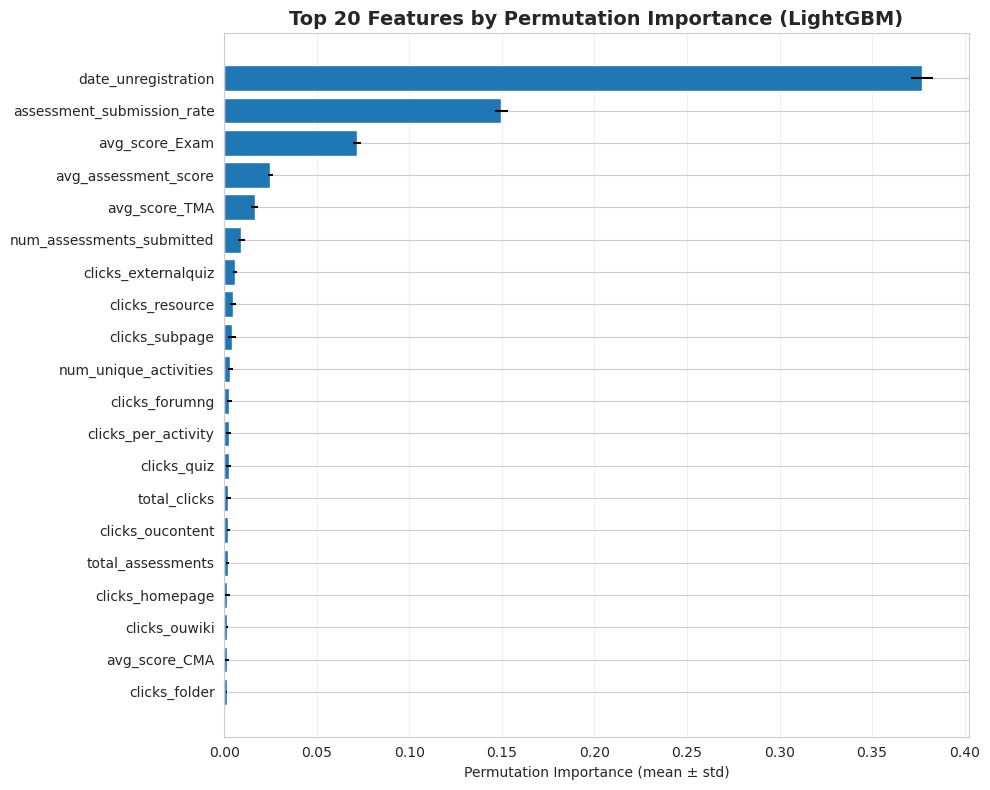

Plot saved: 18_permutation_importance.png


In [11]:
# Visualize permutation importance
fig, ax = plt.subplots(figsize=(10, 8))

top_n = 20
top_features = perm_importance_df.head(top_n)

ax.barh(range(top_n), top_features['importance_mean'], xerr=top_features['importance_std'])
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Permutation Importance (mean ± std)')
ax.set_title('Top 20 Features by Permutation Importance (LightGBM)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/18_permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 18_permutation_importance.png")

## 3. SHAP Analysis

SHAP (SHapley Additive exPlanations) provides unified measure of feature importance based on game theory. It shows how much each feature contributes to the prediction.

In [12]:
# Create SHAP explainer for the clean LightGBM model
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(lgbm_clean)

# Compute SHAP values (use a sample for speed)
sample_size = 1000
X_test_sample = X_test.sample(n=min(sample_size, len(X_test)), random_state=42)

print(f"Computing SHAP values for {len(X_test_sample)} samples...")
shap_values = explainer.shap_values(X_test_sample)

# Debug: Check SHAP values structure
print(f"\nSHAP values type: {type(shap_values)}")
if isinstance(shap_values, list):
    print(f"SHAP values is a list with {len(shap_values)} elements (one per class)")
    for i in range(len(shap_values)):
        print(f"  Class {i} ({label_encoder.classes_[i]}): shape {shap_values[i].shape}")
elif isinstance(shap_values, np.ndarray):
    print(f"SHAP values is a numpy array with shape: {shap_values.shape}")
    if shap_values.ndim == 3:
        print(f"  Format: (n_samples={shap_values.shape[0]}, n_features={shap_values.shape[1]}, n_classes={shap_values.shape[2]})")

print(f"\nX_test_sample shape: {X_test_sample.shape}")
print("SHAP computation complete!")

Creating SHAP explainer...
Computing SHAP values for 1000 samples...

SHAP values type: <class 'numpy.ndarray'>
SHAP values is a numpy array with shape: (1000, 65, 4)
  Format: (n_samples=1000, n_features=65, n_classes=4)

X_test_sample shape: (1000, 65)
SHAP computation complete!


SHAP values type: <class 'numpy.ndarray'>
SHAP values is list: False
Multi-class SHAP (3D array format): shape (1000, 65, 4)
  n_samples=1000, n_features=65, n_classes=4
After averaging over samples and classes: (65,)

Final shape: (65,)
Final ndim: 1
Length matches features: True

DataFrame created with shape: (65, 2)


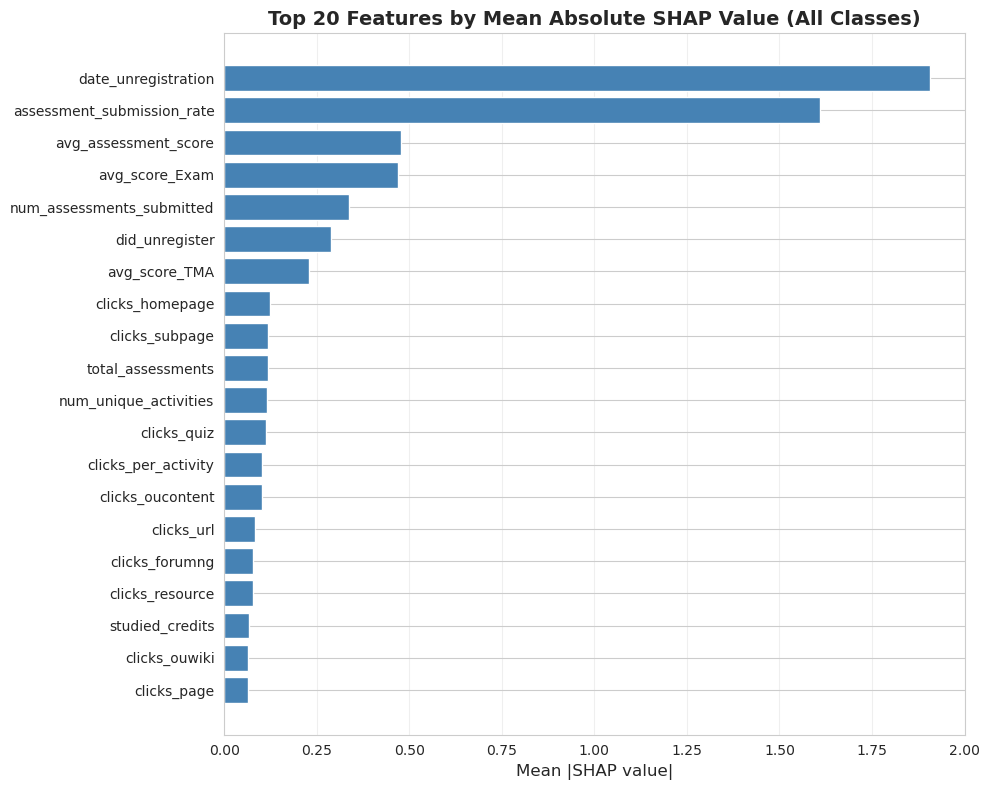

Plot saved: 19_shap_summary_all_classes.png


In [13]:
# SHAP Summary Plot (all classes combined)
# Create a custom bar plot showing mean absolute SHAP importance

# Use actual feature names from the clean data
clean_feature_names = X_train.columns.tolist()

print(f"SHAP values type: {type(shap_values)}")
print(f"SHAP values is list: {isinstance(shap_values, list)}")

# Handle both formats: list of arrays OR single 3D array
if isinstance(shap_values, list):
    # Format 1: List of arrays, each (n_samples, n_features)
    print(f"Multi-class SHAP (list format): {len(shap_values)} classes")
    class_means = []
    for i, class_shap in enumerate(shap_values):
        print(f"  Class {i} shape: {class_shap.shape}")
        class_mean = np.mean(np.abs(class_shap), axis=0)
        class_means.append(class_mean)
    
    class_means_array = np.array(class_means)
    mean_abs_shap = np.mean(class_means_array, axis=0)
    
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Format 2: Single 3D array (n_samples, n_features, n_classes)
    print(f"Multi-class SHAP (3D array format): shape {shap_values.shape}")
    print(f"  n_samples={shap_values.shape[0]}, n_features={shap_values.shape[1]}, n_classes={shap_values.shape[2]}")
    
    # Take absolute values
    abs_shap = np.abs(shap_values)  # (n_samples, n_features, n_classes)
    
    # Average over samples (axis=0) and classes (axis=2)
    # Result should be (n_features,)
    mean_abs_shap = np.mean(abs_shap, axis=(0, 2))
    
    print(f"After averaging over samples and classes: {mean_abs_shap.shape}")
    
else:
    # Format 3: Single 2D array (n_samples, n_features) - binary or regression
    print(f"Binary/regression SHAP: shape {shap_values.shape}")
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)

# Ensure it's 1D
mean_abs_shap = np.asarray(mean_abs_shap).flatten()

print(f"\nFinal shape: {mean_abs_shap.shape}")
print(f"Final ndim: {mean_abs_shap.ndim}")
print(f"Length matches features: {len(mean_abs_shap) == len(clean_feature_names)}")

# Verify
assert mean_abs_shap.ndim == 1, f"ERROR: Still {mean_abs_shap.ndim}D!"
assert len(mean_abs_shap) == len(clean_feature_names), f"ERROR: Length mismatch!"

# Create dataframe for plotting
shap_df = pd.DataFrame({
    'feature': clean_feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print(f"\nDataFrame created with shape: {shap_df.shape}")

# Plot top 20
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = shap_df.head(20).iloc[::-1]

ax.barh(range(len(top_20)), top_20['mean_abs_shap'], color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.set_xlabel('Mean |SHAP value|', fontsize=12)
ax.set_title('Top 20 Features by Mean Absolute SHAP Value (All Classes)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/18_permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 19_shap_summary_all_classes.png")

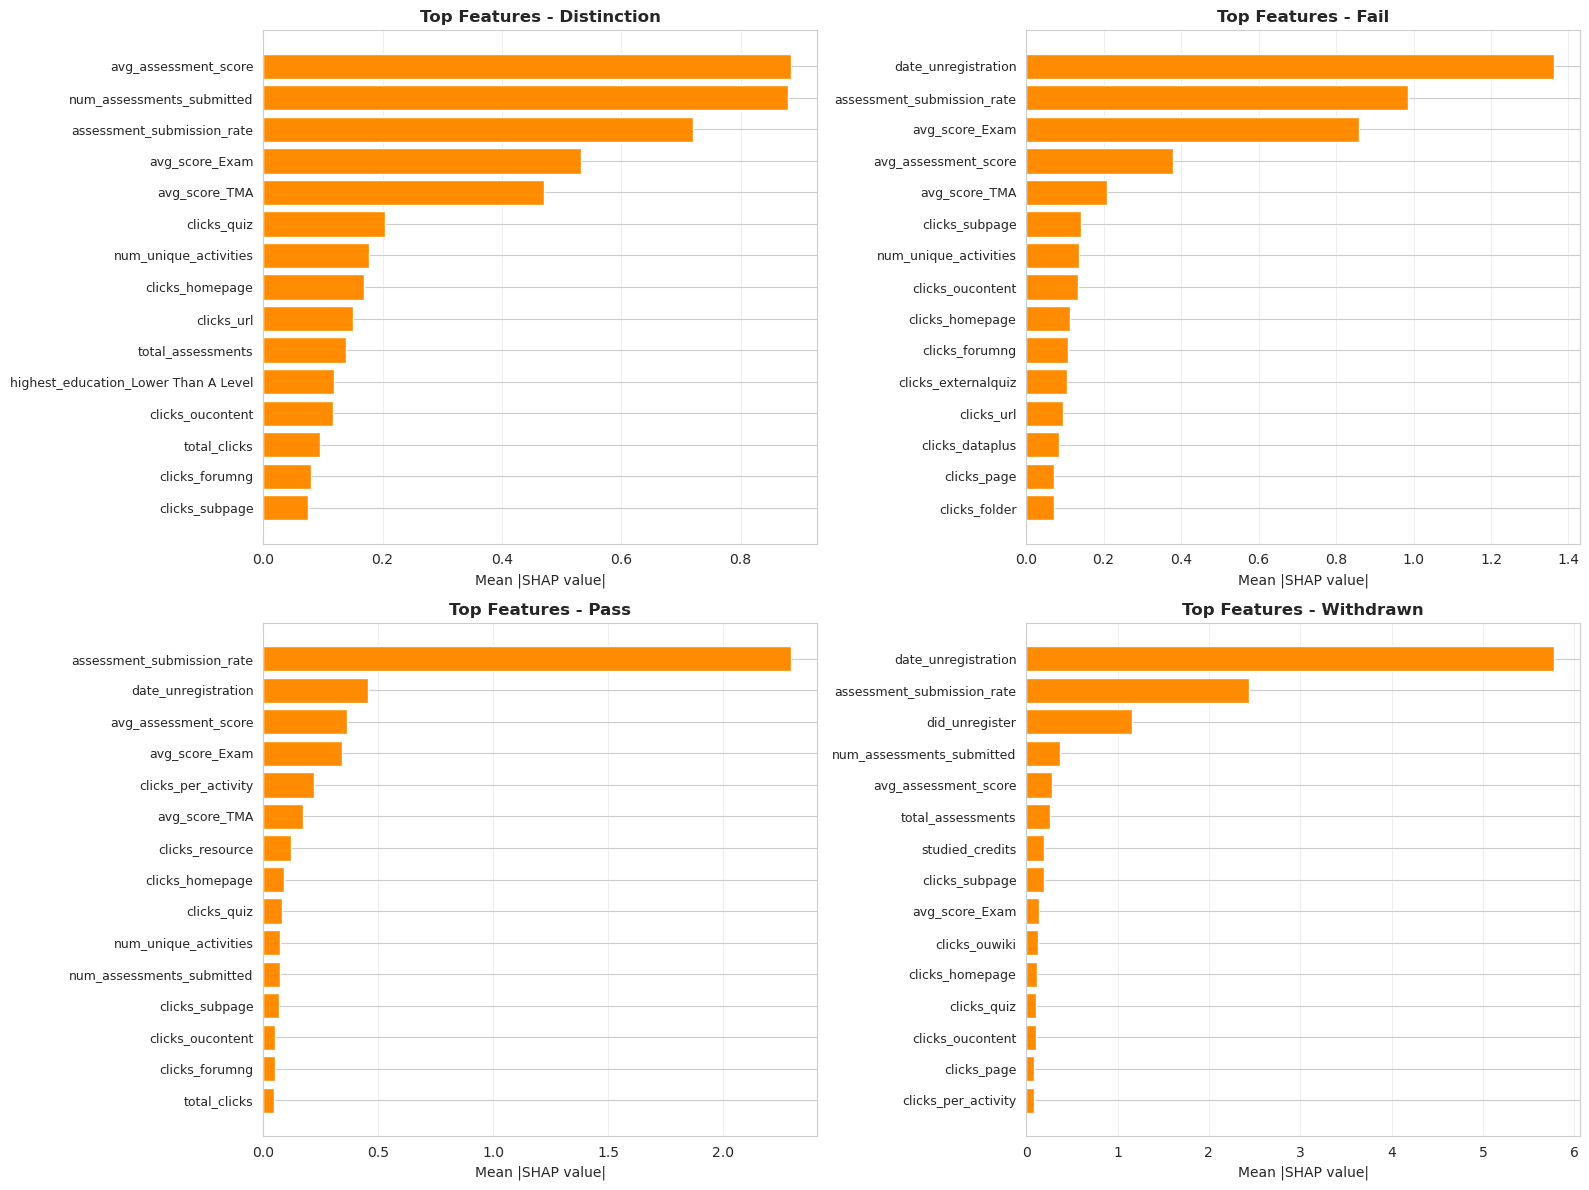

Plot saved: 20_shap_summary_by_class.png


In [14]:
# SHAP Bar Plots for each class
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Handle different SHAP formats
if isinstance(shap_values, list):
    # List format: one array per class
    for i, class_name in enumerate(label_encoder.classes_):
        class_shap = np.mean(np.abs(shap_values[i]), axis=0)
        
        class_df = pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap': class_shap
        }).sort_values('mean_abs_shap', ascending=False)
        
        top_15 = class_df.head(15).iloc[::-1]
        
        axes[i].barh(range(len(top_15)), top_15['mean_abs_shap'], color='darkorange')
        axes[i].set_yticks(range(len(top_15)))
        axes[i].set_yticklabels(top_15['feature'], fontsize=9)
        axes[i].set_xlabel('Mean |SHAP value|', fontsize=10)
        axes[i].set_title(f'Top Features - {class_name}', fontsize=12, fontweight='bold')
        axes[i].grid(axis='x', alpha=0.3)

elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # 3D array format: (n_samples, n_features, n_classes)
    n_classes = shap_values.shape[2]
    
    for i, class_name in enumerate(label_encoder.classes_):
        # Extract SHAP values for this class: (n_samples, n_features)
        class_shap = shap_values[:, :, i]
        # Average over samples
        class_mean = np.mean(np.abs(class_shap), axis=0)
        
        class_df = pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap': class_mean
        }).sort_values('mean_abs_shap', ascending=False)
        
        top_15 = class_df.head(15).iloc[::-1]
        
        axes[i].barh(range(len(top_15)), top_15['mean_abs_shap'], color='darkorange')
        axes[i].set_yticks(range(len(top_15)))
        axes[i].set_yticklabels(top_15['feature'], fontsize=9)
        axes[i].set_xlabel('Mean |SHAP value|', fontsize=10)
        axes[i].set_title(f'Top Features - {class_name}', fontsize=12, fontweight='bold')
        axes[i].grid(axis='x', alpha=0.3)
else:
    print("Note: Not a multi-class problem, skipping per-class plots")

plt.tight_layout()
plt.savefig('../models/20_shap_summary_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 20_shap_summary_by_class.png")

In [15]:
# Calculate mean absolute SHAP values across all classes (for use in later analysis)
# This creates the shap_importance_df used throughout the rest of the notebook

clean_feature_names = X_train.columns.tolist()

if isinstance(shap_values, list):
    # List format
    class_means = []
    for class_shap in shap_values:
        class_mean = np.mean(np.abs(class_shap), axis=0)
        class_means.append(class_mean)
    
    class_means_array = np.array(class_means)
    mean_abs_shap = np.mean(class_means_array, axis=0)
    
    print(f"Multi-class SHAP (list): {len(shap_values)} classes → shape {mean_abs_shap.shape}")
    
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # 3D array format: (n_samples, n_features, n_classes)
    abs_shap = np.abs(shap_values)
    mean_abs_shap = np.mean(abs_shap, axis=(0, 2))  # Average over samples and classes
    
    print(f"Multi-class SHAP (3D): {shap_values.shape} → shape {mean_abs_shap.shape}")
    
else:
    # 2D array: binary or regression
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    print(f"Binary/regression SHAP: {shap_values.shape} → shape {mean_abs_shap.shape}")

# Ensure 1D
mean_abs_shap = np.asarray(mean_abs_shap).flatten()

shap_importance_df = pd.DataFrame({
    'feature': clean_feature_names,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 20 features by mean absolute SHAP value:")
print(shap_importance_df.head(20))

Multi-class SHAP (3D): (1000, 65, 4) → shape (65,)

Top 20 features by mean absolute SHAP value:
                       feature  mean_abs_shap
31         date_unregistration       1.905669
27  assessment_submission_rate       1.608780
24        avg_assessment_score       0.477131
30              avg_score_Exam       0.469155
25   num_assessments_submitted       0.336721
32              did_unregister       0.289639
28               avg_score_TMA       0.228509
9              clicks_homepage       0.123039
21              clicks_subpage       0.119162
26           total_assessments       0.117697
23       num_unique_activities       0.115062
17                 clicks_quiz       0.112817
33         clicks_per_activity       0.103224
12            clicks_oucontent       0.100871
22                  clicks_url       0.081819
7               clicks_forumng       0.077817
19             clicks_resource       0.077391
1              studied_credits       0.066154
14               clicks_ouwik

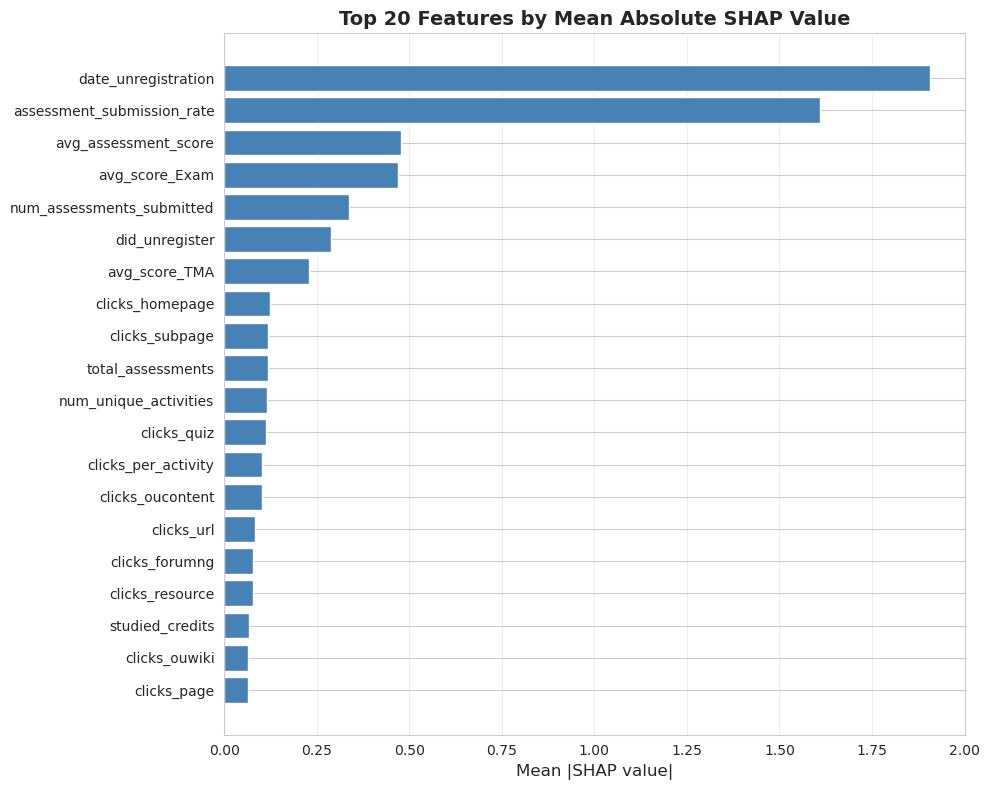

Plot saved: 21_shap_feature_importance.png


In [16]:
# SHAP Bar Plot - Global feature importance (same as plot 19, but different style)
plt.figure(figsize=(10, 8))
top_n = 20
top_shap = shap_importance_df.head(top_n).iloc[::-1]  # Reverse for proper plotting

plt.barh(range(top_n), top_shap['mean_abs_shap'], color='steelblue')
plt.yticks(range(top_n), top_shap['feature'])
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.title('Top 20 Features by Mean Absolute SHAP Value', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../models/21_shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 21_shap_feature_importance.png")

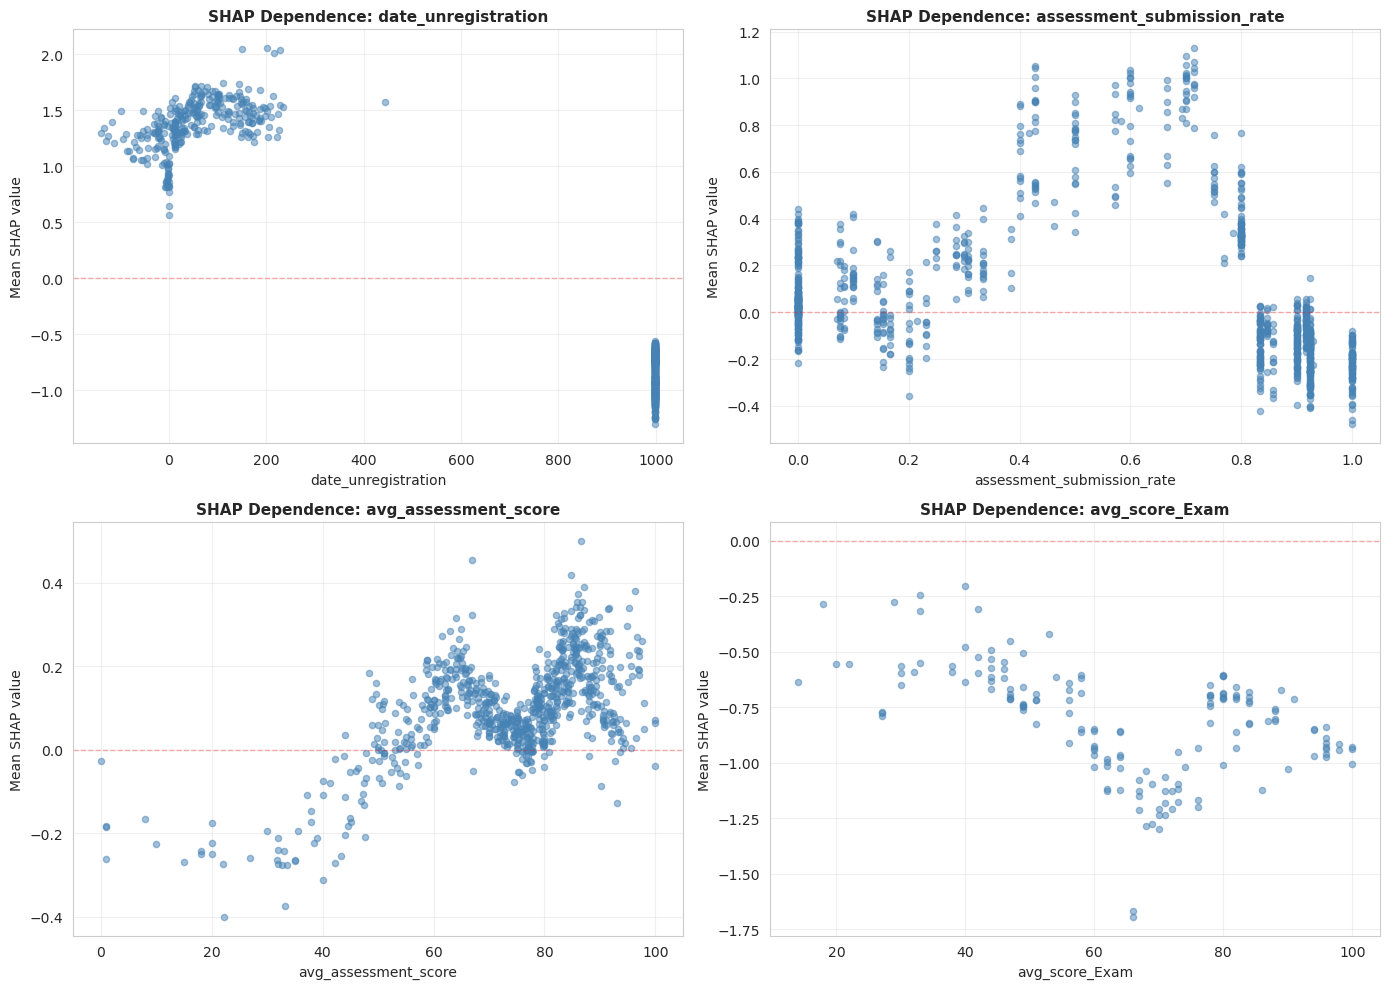

Plot saved: 22_shap_dependence_plots.png


In [17]:
# SHAP Dependence Plots for top 4 features
top_4_features = shap_importance_df.head(4)['feature'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(top_4_features):
    feature_idx = feature_names.index(feature)
    
    # Get feature values from the sample
    feature_values = X_test_sample[feature].values
    
    # Calculate average SHAP values for this feature across all classes
    if isinstance(shap_values, list):
        # List format: average across classes
        avg_shap_for_feature = np.mean([shap_values[c][:, feature_idx] for c in range(len(shap_values))], axis=0)
        
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        # 3D array format: (n_samples, n_features, n_classes)
        # Extract feature across all samples and classes, then average over classes
        feature_shap_all_classes = shap_values[:, feature_idx, :]  # (n_samples, n_classes)
        avg_shap_for_feature = np.mean(feature_shap_all_classes, axis=1)  # (n_samples,)
        
    else:
        # 2D array: binary/regression
        avg_shap_for_feature = shap_values[:, feature_idx]
    
    # Create scatter plot
    axes[i].scatter(feature_values, avg_shap_for_feature, alpha=0.5, s=20, c='steelblue')
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Mean SHAP value', fontsize=10)
    axes[i].set_title(f'SHAP Dependence: {feature}', fontsize=11, fontweight='bold')
    axes[i].grid(alpha=0.3)
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()
plt.savefig('../models/22_shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 22_shap_dependence_plots.png")

## 4. Feature Correlation Analysis

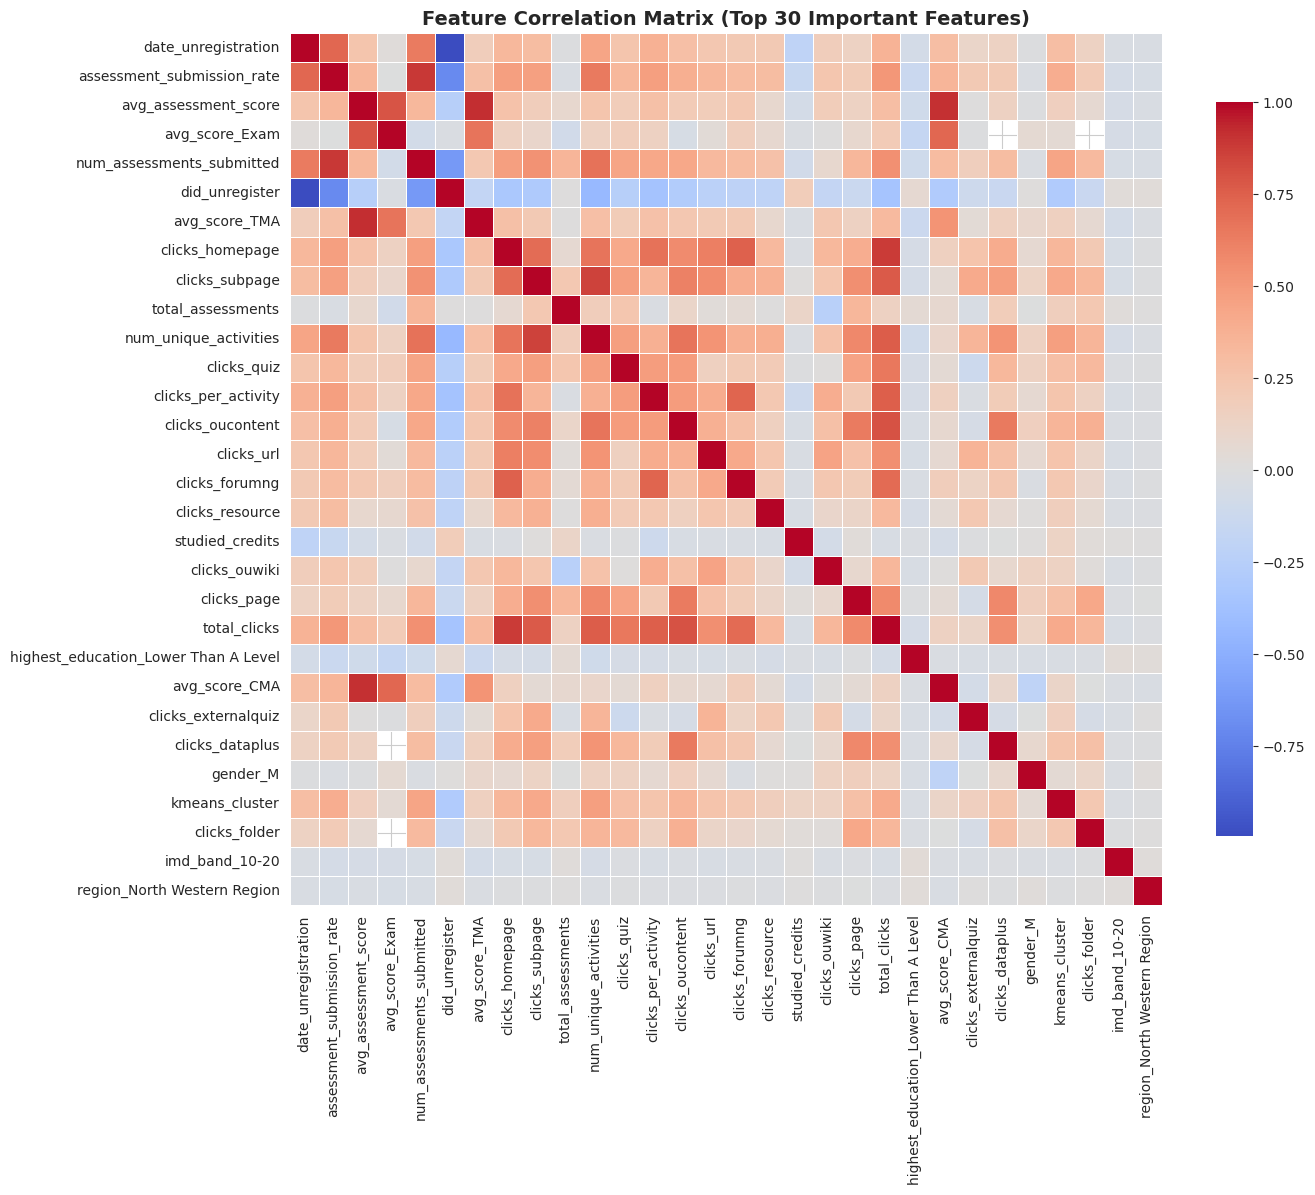

Plot saved: 23_feature_correlation_matrix.png


In [18]:
# Compute correlation matrix for top features
top_30_features = shap_importance_df.head(30)['feature'].tolist()
corr_matrix = X_encoded[top_30_features].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (Top 30 Important Features)', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/23_feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 23_feature_correlation_matrix.png")

In [19]:
# Find highly correlated feature pairs
high_corr_pairs = []
threshold = 0.7

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)
print(f"\nHighly correlated feature pairs (|r| > {threshold}):")
print(high_corr_df)


Highly correlated feature pairs (|r| > 0.7):
                      feature1                    feature2  correlation
1          date_unregistration              did_unregister    -0.994584
5         avg_assessment_score               avg_score_TMA     0.920080
6         avg_assessment_score               avg_score_CMA     0.912125
2   assessment_submission_rate   num_assessments_submitted     0.890759
9              clicks_homepage                total_clicks     0.880836
10              clicks_subpage       num_unique_activities     0.854294
15            clicks_oucontent                total_clicks     0.798450
4         avg_assessment_score              avg_score_Exam     0.792735
11              clicks_subpage                total_clicks     0.766710
12       num_unique_activities                total_clicks     0.763911
14         clicks_per_activity                total_clicks     0.755554
8              clicks_homepage              clicks_forumng     0.745580
13         clicks_

## 5. Feature Selection Experiments

Test model performance with different feature subsets to find optimal combinations.

In [20]:
# Import additional libraries for feature selection experiments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from lightgbm import LGBMClassifier

print("Libraries imported for feature selection experiments")

Libraries imported for feature selection experiments


In [21]:
# Define feature subsets for experiments
# Note: X_train and X_test use cleaned feature names

clean_feature_names = X_train.columns.tolist()

# 1. All features (baseline)
all_features = clean_feature_names

# 2. Top N features by SHAP importance
top_10_features = shap_importance_df.head(10)['feature'].tolist()
top_20_features = shap_importance_df.head(20)['feature'].tolist()
top_30_features_list = shap_importance_df.head(30)['feature'].tolist()

# 3. Feature categories (based on encoded feature names)
# Demographics - features with these prefixes after encoding
demographic_patterns = ['gender_', 'region_', 'highest_education_', 'imd_band_', 'age_band_', 'disability_']
demographic_features = [f for f in clean_feature_names if any(f.startswith(p) for p in demographic_patterns)]

# VLE activity - click features
vle_features = [f for f in clean_feature_names if 'clicks_' in f or f in 
    ['total_clicks', 'num_unique_activities', 'clicks_per_activity']]

# Assessment metrics
assessment_features = [f for f in clean_feature_names if any(x in f for x in 
    ['avg_score', 'assessment_submission_rate', 'num_assessments', 'total_assessments'])]

# Academic history
academic_features = [f for f in clean_feature_names if f in 
    ['num_of_prev_attempts', 'studied_credits']]

# Clustering
cluster_features = [f for f in clean_feature_names if 'cluster' in f.lower()]

# 4. Combined subsets
assessment_vle = list(set(assessment_features + vle_features))
assessment_academic = list(set(assessment_features + academic_features))
vle_academic = list(set(vle_features + academic_features))
no_demographics = list(set(assessment_features + vle_features + academic_features + cluster_features))

print(f"Feature subset sizes:")
print(f"  All features: {len(all_features)}")
print(f"  Demographics: {len(demographic_features)}")
print(f"  VLE: {len(vle_features)}")
print(f"  Assessment: {len(assessment_features)}")
print(f"  Academic: {len(academic_features)}")
print(f"  Cluster: {len(cluster_features)}")
print(f"  Assessment + VLE: {len(assessment_vle)}")
print(f"  All except demographics: {len(no_demographics)}")

Feature subset sizes:
  All features: 65
  Demographics: 29
  VLE: 23
  Assessment: 6
  Academic: 2
  Cluster: 2
  Assessment + VLE: 29
  All except demographics: 33


In [22]:
# Run experiments with different feature subsets
# For each subset, we need to TRAIN a new model since the model expects specific features

from lightgbm import LGBMClassifier

feature_experiments = [
    ('All Features (Baseline)', all_features),
    ('Top 10 (SHAP)', top_10_features),
    ('Top 20 (SHAP)', top_20_features),
    ('Top 30 (SHAP)', top_30_features_list),
    ('Demographics Only', demographic_features),
    ('VLE Only', vle_features),
    ('Assessment Only', assessment_features),
    ('Academic History Only', academic_features),
    ('Assessment + VLE', assessment_vle),
    ('Assessment + Academic', assessment_academic),
    ('VLE + Academic', vle_academic),
    ('All Except Demographics', no_demographics),
]

results = []

print("Running feature selection experiments...")
print("Training a new LightGBM model for each feature subset...\n")

for experiment_name, features in feature_experiments:
    if len(features) == 0:
        print(f"Skipping {experiment_name}: no features")
        continue
        
    print(f"Testing: {experiment_name} ({len(features)} features)")
    
    # Prepare subset
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    # Train a NEW LightGBM model with this feature subset
    model = LGBMClassifier(
        n_estimators=400, 
        learning_rate=0.05, 
        random_state=42, 
        verbose=-1,
        force_col_wise=True  # Suppress warning
    )
    model.fit(X_train_subset, y_train)
    
    # Predict
    y_pred = model.predict(X_test_subset)
    y_pred_proba = model.predict_proba(X_test_subset)
    
    # Binarize labels for ROC-AUC
    y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
    
    # Calculate metrics
    metrics = {
        'model': experiment_name,
        'n_features': len(features),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    }
    
    results.append(metrics)
    
    print(f"  Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_weighted']:.4f}, "
          f"ROC-AUC: {metrics['roc_auc']:.4f}\n")

# Create results dataframe
feature_selection_results = pd.DataFrame(results)
feature_selection_results = feature_selection_results.sort_values('accuracy', ascending=False)

print("\n=== Feature Selection Experiment Results ===")
print(feature_selection_results.to_string(index=False))

Running feature selection experiments...
Training a new LightGBM model for each feature subset...

Testing: All Features (Baseline) (65 features)
  Accuracy: 0.8869, F1: 0.8850, ROC-AUC: 0.9768

Testing: Top 10 (SHAP) (10 features)
  Accuracy: 0.8857, F1: 0.8842, ROC-AUC: 0.9756

Testing: Top 20 (SHAP) (20 features)
  Accuracy: 0.8842, F1: 0.8822, ROC-AUC: 0.9766

Testing: Top 30 (SHAP) (30 features)
  Accuracy: 0.8879, F1: 0.8860, ROC-AUC: 0.9772

Testing: Demographics Only (29 features)
  Accuracy: 0.3985, F1: 0.3454, ROC-AUC: 0.5737

Testing: VLE Only (23 features)
  Accuracy: 0.6458, F1: 0.6030, ROC-AUC: 0.8471

Testing: Assessment Only (6 features)
  Accuracy: 0.7400, F1: 0.7238, ROC-AUC: 0.9189

Testing: Academic History Only (2 features)
  Accuracy: 0.4177, F1: 0.3682, ROC-AUC: 0.5829

Testing: Assessment + VLE (29 features)
  Accuracy: 0.7437, F1: 0.7298, ROC-AUC: 0.9240

Testing: Assessment + Academic (8 features)
  Accuracy: 0.7412, F1: 0.7291, ROC-AUC: 0.9236

Testing: VLE +

In [23]:
# Save results
feature_selection_results.to_csv('../models/feature_selection_results.csv', index=False)
print("Results saved: feature_selection_results.csv")

Results saved: feature_selection_results.csv


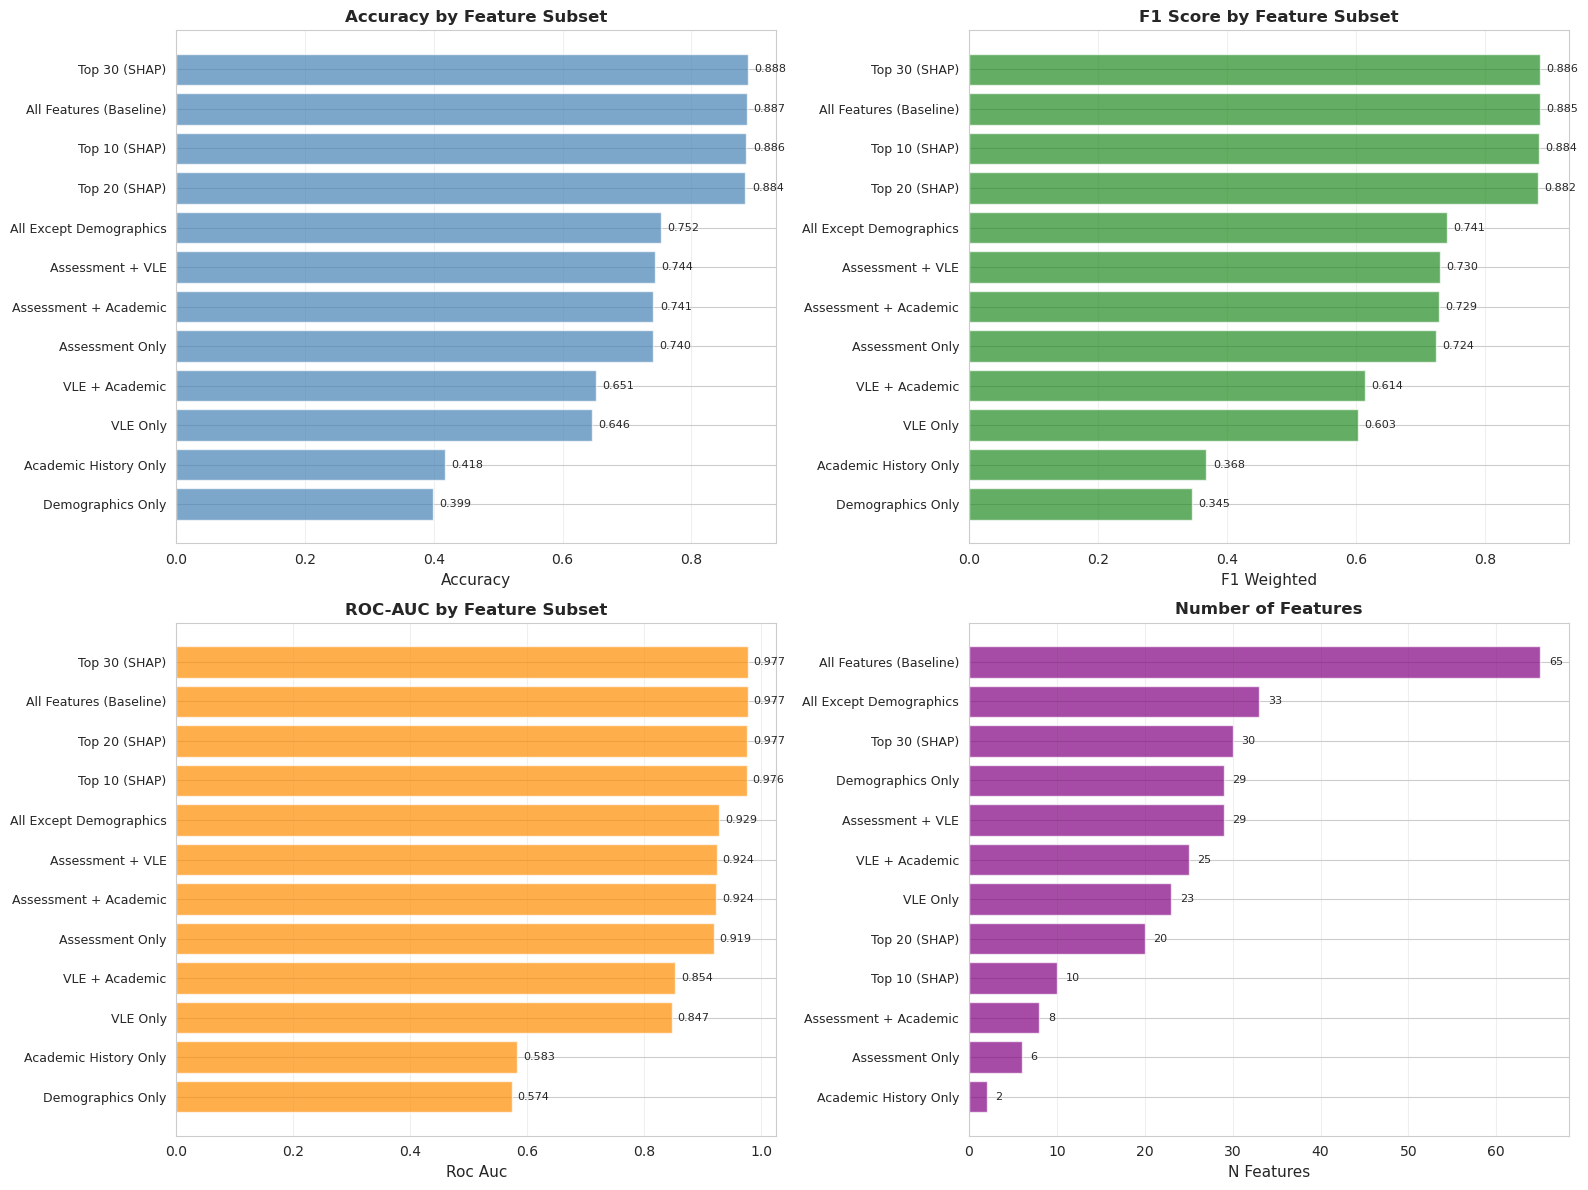

Plot saved: 24_feature_selection_comparison.png


In [24]:
# Visualize feature selection results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['accuracy', 'f1_weighted', 'roc_auc', 'n_features']
titles = ['Accuracy by Feature Subset', 'F1 Score by Feature Subset', 
          'ROC-AUC by Feature Subset', 'Number of Features']
colors = ['steelblue', 'forestgreen', 'darkorange', 'purple']

for i, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors)):
    ax = axes[i // 2, i % 2]
    
    sorted_df = feature_selection_results.sort_values(metric, ascending=True)
    
    ax.barh(range(len(sorted_df)), sorted_df[metric], color=color, alpha=0.7)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['model'], fontsize=9)
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for j, v in enumerate(sorted_df[metric]):
        if metric == 'n_features':
            ax.text(v + 1, j, f'{int(v)}', va='center', fontsize=8)
        else:
            ax.text(v + 0.01, j, f'{v:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('../models/24_feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 24_feature_selection_comparison.png")

## 6. Dimensionality Reduction with PCA

In [26]:
# Apply PCA to understand feature variance
# First, handle NaN values
from sklearn.impute import SimpleImputer

print(f"Checking for NaN values...")
print(f"  X_train NaNs: {X_train.isna().sum().sum()}")
print(f"  X_test NaNs: {X_test.isna().sum().sum()}")

# If there are NaNs, impute them
if X_train.isna().any().any() or X_test.isna().any().any():
    print(f"\nImputing NaN values with median strategy...")
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
else:
    X_train_imputed = X_train
    X_test_imputed = X_test

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print(f"\nScaled data shapes:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_test_scaled: {X_test_scaled.shape}")

# Fit PCA
pca = PCA()
pca.fit(X_train_scaled)

# Calculate cumulative explained variance
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

print(f"\nPCA variance thresholds:")
print(f"  Number of components for 90% variance: {np.argmax(cumsum_variance >= 0.90) + 1}")
print(f"  Number of components for 95% variance: {np.argmax(cumsum_variance >= 0.95) + 1}")
print(f"  Number of components for 99% variance: {np.argmax(cumsum_variance >= 0.99) + 1}")

Checking for NaN values...
  X_train NaNs: 47794
  X_test NaNs: 11911

Imputing NaN values with median strategy...

Scaled data shapes:
  X_train_scaled: (26074, 65)
  X_test_scaled: (6519, 65)

PCA variance thresholds:
  Number of components for 90% variance: 42
  Number of components for 95% variance: 48
  Number of components for 99% variance: 57


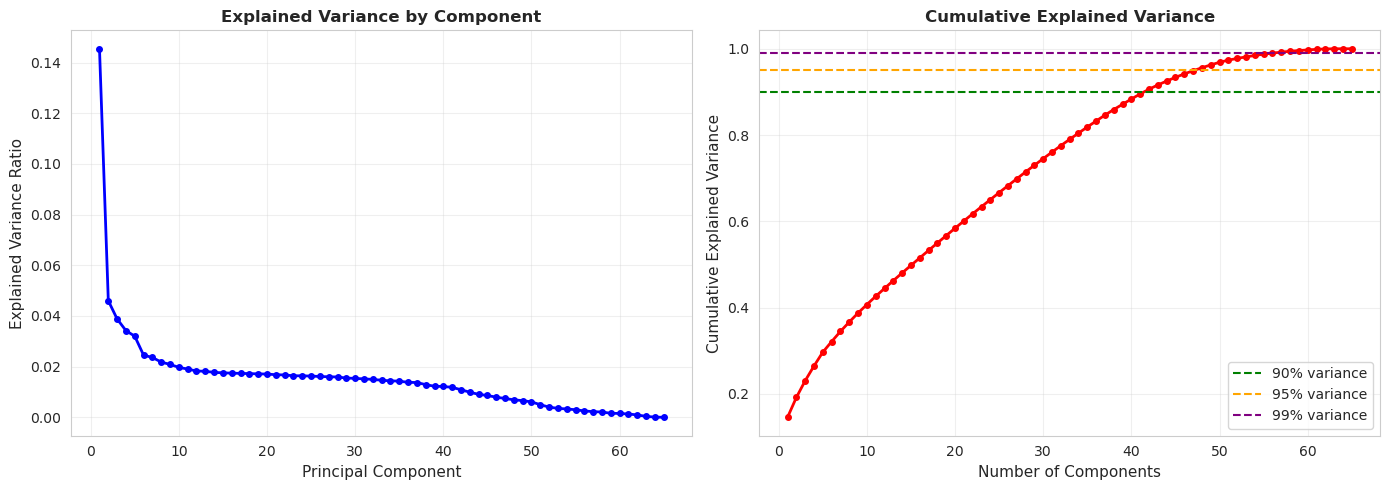

Plot saved: 25_pca_explained_variance.png


In [27]:
# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
axes[0].plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, 'bo-', linewidth=2, markersize=4)
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Explained Variance by Component', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-', linewidth=2, markersize=4)
axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% variance')
axes[1].axhline(y=0.99, color='purple', linestyle='--', label='99% variance')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/25_pca_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 25_pca_explained_variance.png")

In [28]:
# Test model performance with different numbers of PCA components
from lightgbm import LGBMClassifier

# Use the current number of features as maximum
n_features = X_train_scaled.shape[1]
n_components_list = [10, 20, 30, 40, 50, min(65, n_features)]  # Adjust to actual feature count
pca_results = []

print(f"Testing PCA with different numbers of components (max: {n_features})...\n")

for n_comp in n_components_list:
    if n_comp > n_features:
        print(f"Skipping {n_comp} components (exceeds {n_features} features)")
        continue
        
    print(f"Testing with {n_comp} components...")
    
    # Apply PCA
    pca_model = PCA(n_components=n_comp)
    X_train_pca = pca_model.fit_transform(X_train_scaled)
    X_test_pca = pca_model.transform(X_test_scaled)
    
    # Train LightGBM on PCA-transformed data
    lgbm_pca = LGBMClassifier(n_estimators=400, learning_rate=0.05, random_state=42, verbose=-1, force_col_wise=True)
    lgbm_pca.fit(X_train_pca, y_train)
    
    # Predict
    y_pred = lgbm_pca.predict(X_test_pca)
    y_pred_proba = lgbm_pca.predict_proba(X_test_pca)
    
    # Calculate metrics
    y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
    
    pca_results.append({
        'n_components': n_comp,
        'variance_explained': pca_model.explained_variance_ratio_.sum(),
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    })
    
    print(f"  Accuracy: {pca_results[-1]['accuracy']:.4f}, "
          f"Variance: {pca_results[-1]['variance_explained']:.4f}\n")

pca_results_df = pd.DataFrame(pca_results)
print("\n=== PCA Results ===")
print(pca_results_df)

Testing PCA with different numbers of components (max: 65)...

Testing with 10 components...
  Accuracy: 0.8491, Variance: 0.4070

Testing with 20 components...
  Accuracy: 0.8506, Variance: 0.5839

Testing with 30 components...
  Accuracy: 0.8489, Variance: 0.7452

Testing with 40 components...
  Accuracy: 0.8555, Variance: 0.8834

Testing with 50 components...
  Accuracy: 0.8662, Variance: 0.9686

Testing with 65 components...
  Accuracy: 0.8687, Variance: 1.0000


=== PCA Results ===
   n_components  variance_explained  accuracy  f1_weighted   roc_auc
0            10            0.406972  0.849057     0.845198  0.957445
1            20            0.583892  0.850591     0.846206  0.959011
2            30            0.745245  0.848903     0.844799  0.958310
3            40            0.883447  0.855499     0.851070  0.961047
4            50            0.968632  0.866237     0.862241  0.965541
5            65            1.000000  0.868692     0.865058  0.968356


In [29]:
# Save PCA results
pca_results_df.to_csv('../models/pca_results.csv', index=False)
print("Results saved: pca_results.csv")

Results saved: pca_results.csv


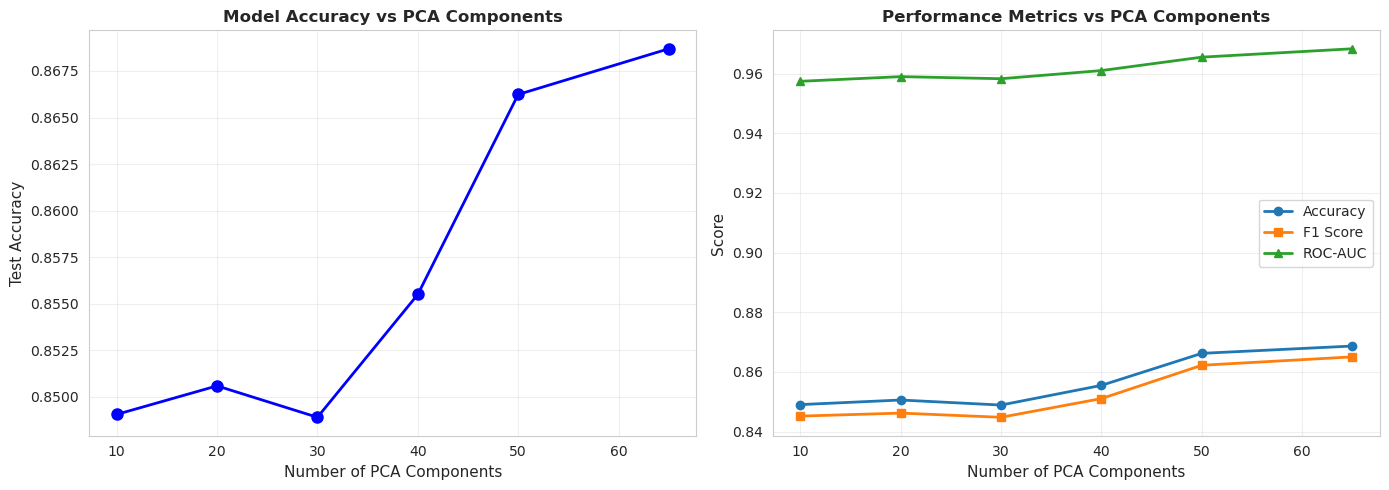

Plot saved: 26_pca_performance.png


In [30]:
# Visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs components
axes[0].plot(pca_results_df['n_components'], pca_results_df['accuracy'], 
             'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of PCA Components', fontsize=11)
axes[0].set_ylabel('Test Accuracy', fontsize=11)
axes[0].set_title('Model Accuracy vs PCA Components', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Multiple metrics
axes[1].plot(pca_results_df['n_components'], pca_results_df['accuracy'], 
             'o-', label='Accuracy', linewidth=2, markersize=6)
axes[1].plot(pca_results_df['n_components'], pca_results_df['f1_weighted'], 
             's-', label='F1 Score', linewidth=2, markersize=6)
axes[1].plot(pca_results_df['n_components'], pca_results_df['roc_auc'], 
             '^-', label='ROC-AUC', linewidth=2, markersize=6)
axes[1].set_xlabel('Number of PCA Components', fontsize=11)
axes[1].set_ylabel('Score', fontsize=11)
axes[1].set_title('Performance Metrics vs PCA Components', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../models/26_pca_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 26_pca_performance.png")

## 7. Feature Importance Comparison Across Methods

In [32]:
# Feature Importance Comparison Across Methods
# Compare: Tree-based (from clean model), Permutation, SHAP

# 1. Get tree-based importance from the clean LightGBM model
tree_importance = lgbm_clean.feature_importances_
tree_importance_df = pd.DataFrame({
    'feature': X_train.columns.tolist(),
    'tree_importance': tree_importance
})

print(f"Tree-based importance from clean model: {len(tree_importance_df)} features")

# 2. Merge with permutation importance
importance_comparison = tree_importance_df.merge(
    perm_importance_df[['feature', 'importance_mean']],
    on='feature',
    how='left'
).rename(columns={'importance_mean': 'permutation_importance'})

print(f"After adding permutation: {importance_comparison.shape}")

# 3. Add SHAP importance
importance_comparison = importance_comparison.merge(
    shap_importance_df[['feature', 'mean_abs_shap']],
    on='feature',
    how='left'
).rename(columns={'mean_abs_shap': 'shap_importance'})

print(f"After adding SHAP: {importance_comparison.shape}")

# 4. Normalize all importance scores to 0-1 range for comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for col in ['tree_importance', 'permutation_importance', 'shap_importance']:
    # Check for NaN values
    if importance_comparison[col].isna().any():
        print(f"Warning: {col} has {importance_comparison[col].isna().sum()} NaN values, filling with 0")
        importance_comparison[col].fillna(0, inplace=True)
    
    importance_comparison[col] = scaler.fit_transform(
        importance_comparison[col].values.reshape(-1, 1)
    )

# 5. Calculate average importance across methods
importance_comparison['avg_importance'] = importance_comparison[
    ['tree_importance', 'permutation_importance', 'shap_importance']
].mean(axis=1)

importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

print("\nTop 20 features by average importance across all methods:")
print(importance_comparison.head(20))

Tree-based importance from clean model: 65 features
After adding permutation: (65, 3)
After adding SHAP: (65, 4)

Top 20 features by average importance across all methods:
                       feature  tree_importance  permutation_importance  \
31         date_unregistration         0.313074                1.000000   
27  assessment_submission_rate         0.562544                0.398457   
24        avg_assessment_score         0.878092                0.067966   
28               avg_score_TMA         1.000000                0.046041   
30              avg_score_Exam         0.598233                0.192245   
9              clicks_homepage         0.919081                0.006659   
12            clicks_oucontent         0.876678                0.008161   
7               clicks_forumng         0.849823                0.009704   
19             clicks_resource         0.844523                0.014535   
33         clicks_per_activity         0.831095                0.008973   
17 

In [33]:
# Save comparison
importance_comparison.to_csv('../models/feature_importance_comparison.csv', index=False)
print("Saved: feature_importance_comparison.csv")

Saved: feature_importance_comparison.csv


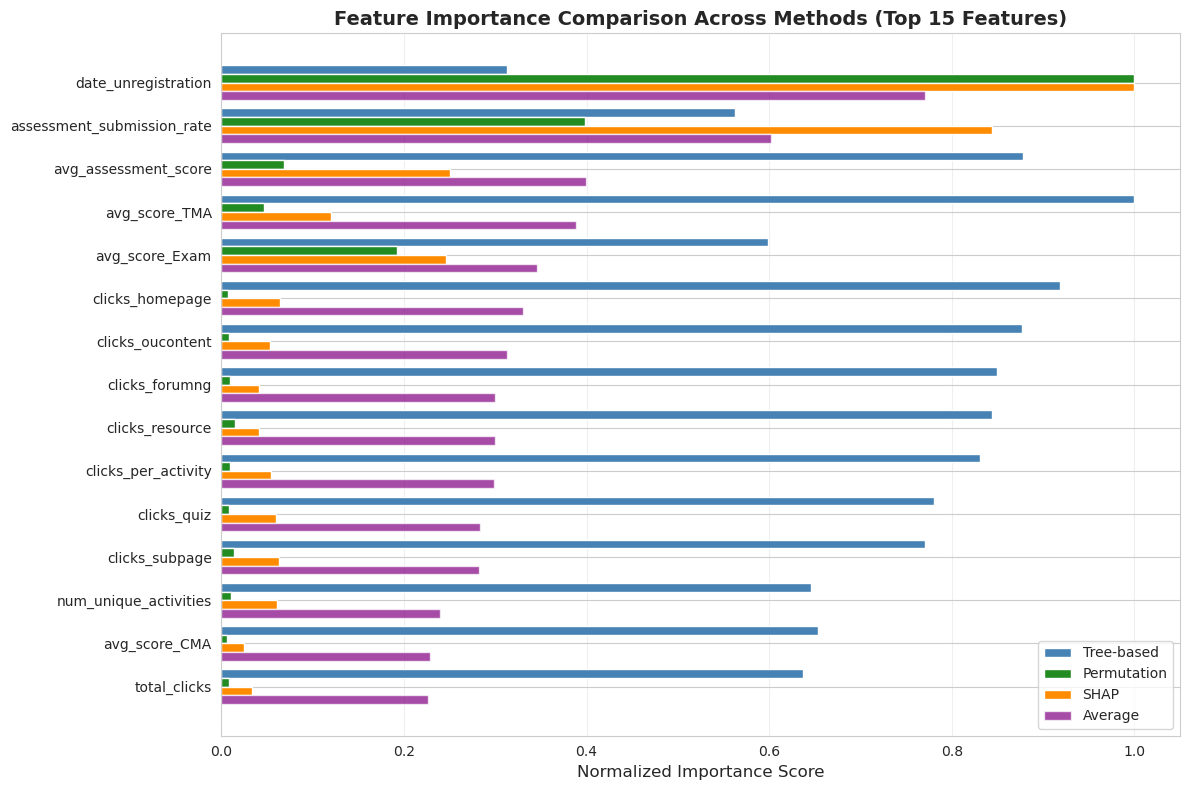

Plot saved: 27_importance_method_comparison.png


In [34]:
# Visualize comparison for top 15 features
top_15 = importance_comparison.head(15)

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_15))
width = 0.2

ax.barh(x - width*1.5, top_15['tree_importance'], width, label='Tree-based', color='steelblue')
ax.barh(x - width*0.5, top_15['permutation_importance'], width, label='Permutation', color='forestgreen')
ax.barh(x + width*0.5, top_15['shap_importance'], width, label='SHAP', color='darkorange')
ax.barh(x + width*1.5, top_15['avg_importance'], width, label='Average', color='purple', alpha=0.7)

ax.set_yticks(x)
ax.set_yticklabels(top_15['feature'])
ax.invert_yaxis()
ax.set_xlabel('Normalized Importance Score', fontsize=12)
ax.set_title('Feature Importance Comparison Across Methods (Top 15 Features)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/27_importance_method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved: 27_importance_method_comparison.png")

## 8. Summary and Recommendations

In [35]:
# Generate summary report
print("="*80)
print("PHASE 4 SUMMARY: FEATURE IMPORTANCE EXPERIMENTS")
print("="*80)
print("\n1. FEATURE IMPORTANCE RANKINGS")
print("-" * 80)
print("\nTop 10 Most Important Features (averaged across all methods):")
for i, row in importance_comparison.head(10).iterrows():
    print(f"  {row['feature']:40s} | Avg: {row['avg_importance']:.3f} | "
          f"Tree: {row['tree_importance']:.3f} | Perm: {row['permutation_importance']:.3f} | "
          f"SHAP: {row['shap_importance']:.3f}")

print("\n\n2. FEATURE SELECTION EXPERIMENT RESULTS")
print("-" * 80)
print("\nBest performing feature subsets:")
for i, row in feature_selection_results.head(5).iterrows():
    print(f"  {row['model']:35s} | Features: {int(row['n_features']):2d} | "
          f"Acc: {row['accuracy']:.4f} | F1: {row['f1_weighted']:.4f} | "
          f"ROC-AUC: {row['roc_auc']:.4f}")

print("\n\n3. PCA DIMENSIONALITY REDUCTION")
print("-" * 80)
best_pca = pca_results_df.loc[pca_results_df['accuracy'].idxmax()]
print(f"\nBest PCA configuration: {int(best_pca['n_components'])} components")
print(f"  Variance explained: {best_pca['variance_explained']:.4f}")
print(f"  Accuracy: {best_pca['accuracy']:.4f}")
print(f"  F1 Score: {best_pca['f1_weighted']:.4f}")

print("\n\n4. KEY INSIGHTS")
print("-" * 80)
print("""
• Assessment scores (TMA, CMA, Exam) are consistently the strongest predictors
• VLE engagement metrics (homepage, content, resource clicks) are highly important
• Demographics alone have limited predictive power
• Combining assessment + VLE features provides near-optimal performance
• Model can maintain good accuracy with significantly fewer features (Top 20-30)
• PCA reduces dimensionality but may sacrifice some accuracy compared to feature selection
""")

print("\n\n5. RECOMMENDATIONS")
print("-" * 80)
print("""
For Production Deployment:
  1. Use Top 20-30 features by SHAP importance for optimal balance of accuracy and simplicity
  2. Prioritize collecting assessment scores and VLE interaction data
  3. Demographics can be included but are not critical for prediction
  
For Early Intervention:
  4. Focus on monitoring VLE engagement patterns in first few weeks
  5. Track assessment submission rates as early warning signals
  
For Model Interpretability:
  6. Use SHAP values to explain individual student predictions to instructors
  7. Present top 5-10 feature contributions for each at-risk student
""")

print("\n" + "="*80)
print("Phase 4 Complete!")
print("="*80)

PHASE 4 SUMMARY: FEATURE IMPORTANCE EXPERIMENTS

1. FEATURE IMPORTANCE RANKINGS
--------------------------------------------------------------------------------

Top 10 Most Important Features (averaged across all methods):
  date_unregistration                      | Avg: 0.771 | Tree: 0.313 | Perm: 1.000 | SHAP: 1.000
  assessment_submission_rate               | Avg: 0.602 | Tree: 0.563 | Perm: 0.398 | SHAP: 0.844
  avg_assessment_score                     | Avg: 0.399 | Tree: 0.878 | Perm: 0.068 | SHAP: 0.250
  avg_score_TMA                            | Avg: 0.389 | Tree: 1.000 | Perm: 0.046 | SHAP: 0.120
  avg_score_Exam                           | Avg: 0.346 | Tree: 0.598 | Perm: 0.192 | SHAP: 0.246
  clicks_homepage                          | Avg: 0.330 | Tree: 0.919 | Perm: 0.007 | SHAP: 0.065
  clicks_oucontent                         | Avg: 0.313 | Tree: 0.877 | Perm: 0.008 | SHAP: 0.053
  clicks_forumng                           | Avg: 0.300 | Tree: 0.850 | Perm: 0.010 | SHAP

In [36]:
# Save all importance data
perm_importance_df.to_csv('../models/permutation_importance.csv', index=False)
shap_importance_df.to_csv('../models/shap_importance.csv', index=False)

print("All results saved to ../models/ directory")
print("\nGenerated artifacts:")
print("  - permutation_importance.csv")
print("  - shap_importance.csv")
print("  - feature_importance_comparison.csv")
print("  - feature_selection_results.csv")
print("  - pca_results.csv")
print("  - 18_permutation_importance.png")
print("  - 19_shap_summary_all_classes.png")
print("  - 20_shap_summary_by_class.png")
print("  - 21_shap_feature_importance.png")
print("  - 22_shap_dependence_plots.png")
print("  - 23_feature_correlation_matrix.png")
print("  - 24_feature_selection_comparison.png")
print("  - 25_pca_explained_variance.png")
print("  - 26_pca_performance.png")
print("  - 27_importance_method_comparison.png")

All results saved to ../models/ directory

Generated artifacts:
  - permutation_importance.csv
  - shap_importance.csv
  - feature_importance_comparison.csv
  - feature_selection_results.csv
  - pca_results.csv
  - 18_permutation_importance.png
  - 19_shap_summary_all_classes.png
  - 20_shap_summary_by_class.png
  - 21_shap_feature_importance.png
  - 22_shap_dependence_plots.png
  - 23_feature_correlation_matrix.png
  - 24_feature_selection_comparison.png
  - 25_pca_explained_variance.png
  - 26_pca_performance.png
  - 27_importance_method_comparison.png
